In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import evofr as ef
from evofr.plotting import *

raw_seq = pd.read_csv("../../HHMI_poster/data/seq_counts_nextstrain_clades_usa.tsv.gz", sep="\t").rename(columns={"clade": "variant"})
raw_cases =  pd.read_csv("../../HHMI_poster/data/case_counts_usa.tsv.gz", sep="\t")

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils

In [7]:
date_end = "2022-03-01"
date_start = "2021-01-01"

raw_seq = raw_seq[raw_seq.date < date_end].copy()
raw_seq = raw_seq[raw_seq.date > date_start].copy()

raw_cases = raw_cases[raw_cases.date < date_end].copy()
raw_cases = raw_cases[raw_cases.date > date_start].copy()

In [20]:
from relative_fitness_hsgp import RelativeFitnessHSGP, SquaredExponential, Matern
import numpyro.distributions as dist

hsgp_mat = Matern(
    L=250, 
    num_basis=35,
    rho = dist.HalfNormal(15),
    alpha = dist.HalfNormal(0.1),
    nu=5/2)
hsgp_sq = SquaredExponential(
    L=180, 
    num_basis=45,
    rho = dist.HalfNormal(15),
    alpha = dist.HalfNormal(1e-2))
model = RelativeFitnessHSGP(hsgp_mat) # Do I need to add intercepts?
inference_method = ef.InferNUTS(num_samples=500, num_warmup=1000)
inference_method = ef.InferMAP(iters=30_000, lr=4e-4)

In [21]:
raw_seq.variant.unique()

array(['19A', '19B', '20A', '20B', '20C', '20D', '20G', '20H', '20I',
       '20J', '21A', '21C', '21D', '21F', '21G', '21H', '21I', '21J',
       '21K', '21L', 'recombinant', '20E', '22E', '22A', '22B', '22C',
       '21B', '21E', '22F', '23A', '21M'], dtype=object)

In [37]:
locations = pd.unique(raw_seq["location"])
locations = ["California", "Florida", "Michigan", "New York", "Georgia", "Washington"]
data = {}
cases = {}
for loc in locations:
    data[loc] = ef.VariantFrequencies(raw_seq[raw_seq.location == loc].copy(), pivot="21K")
    cases[loc] = raw_cases[raw_cases.location == loc].copy()
data

{'California': <evofr.data.variant_frequencies.VariantFrequencies at 0x2c1539410>,
 'Florida': <evofr.data.variant_frequencies.VariantFrequencies at 0x2b9ea9c50>,
 'Michigan': <evofr.data.variant_frequencies.VariantFrequencies at 0x2c2a2f850>,
 'New York': <evofr.data.variant_frequencies.VariantFrequencies at 0x2c40ba1d0>,
 'Georgia': <evofr.data.variant_frequencies.VariantFrequencies at 0x2c2b5c510>,
 'Washington': <evofr.data.variant_frequencies.VariantFrequencies at 0x2c2adec90>}

In [23]:
# Fit models
posteriors = {}
for loc in locations:
    posteriors[loc] = inference_method.fit(model, data=data[loc]) 
posteriors

In [55]:
def compute_selective_pressure(posterior):
    
    delta = posterior.samples["delta"]
    num_samples, T, _ = delta.shape
    delta = jnp.concatenate((delta, jnp.zeros((num_samples,T,1))), axis=-1)
    freq = posterior.samples["freq"]        
        
    # Mean fitness
    delta_bar = (delta * freq).mean(axis=-1)
    
    # Mean square deviation
    delta_sse = jnp.square(delta - delta_bar[..., None])
    selective_pressure_var = (delta_sse * freq).sum(axis=-1)
    
    # Change in relative fitness overall
    selective_pressure_expect = (jnp.diff(delta, axis=1, prepend=0.0) * freq).sum(axis=-1)
    selective_pressure = selective_pressure_var + selective_pressure_expect
    
    return delta_bar.T, selective_pressure.T

In [56]:
delta_bar, selective_pressure = compute_selective_pressure(posteriors["Washington"])

{'California': <Figure size 1200x600 with 2 Axes>,
 'Florida': <Figure size 1200x600 with 2 Axes>,
 'Michigan': <Figure size 1200x600 with 2 Axes>,
 'New York': <Figure size 1200x600 with 2 Axes>,
 'Georgia': <Figure size 1200x600 with 2 Axes>,
 'Washington': <Figure size 1200x600 with 2 Axes>}

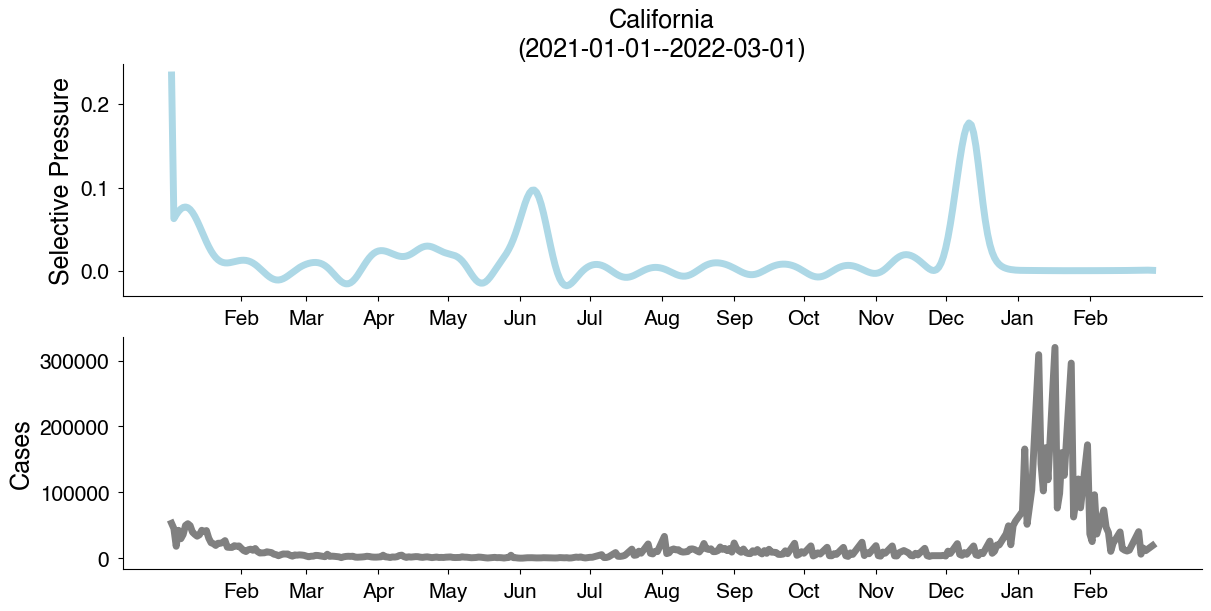

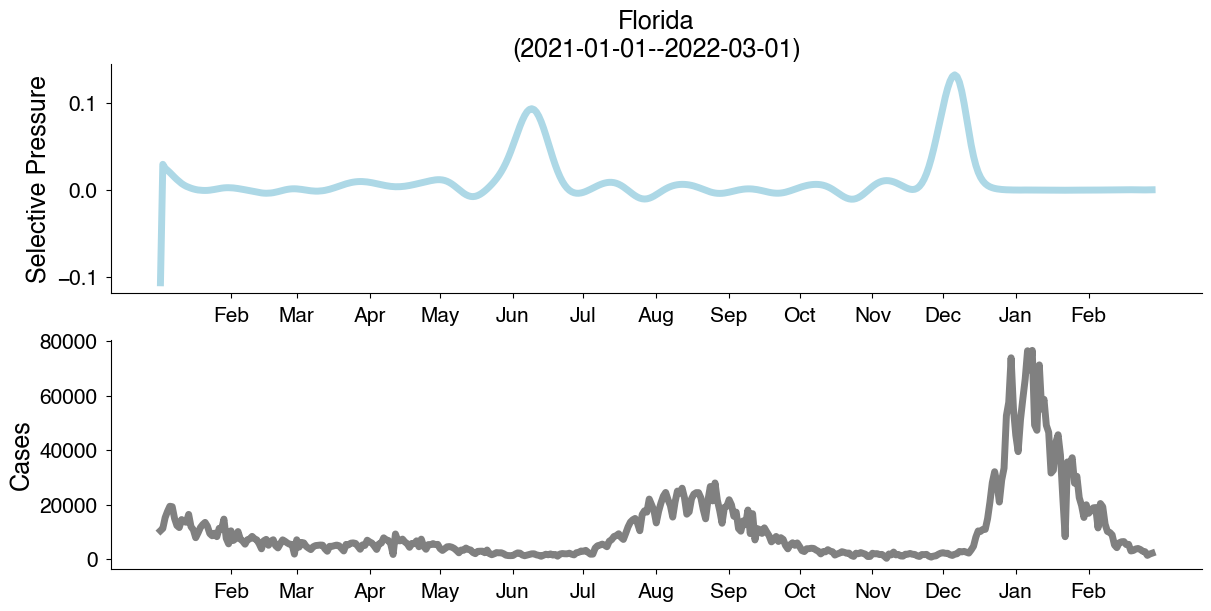

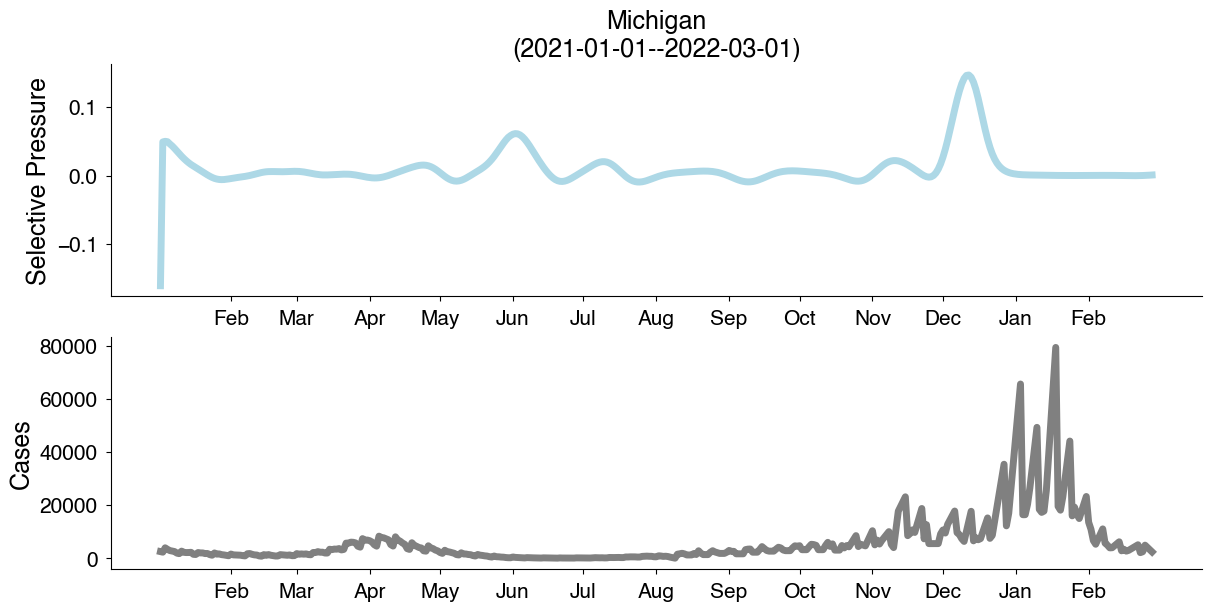

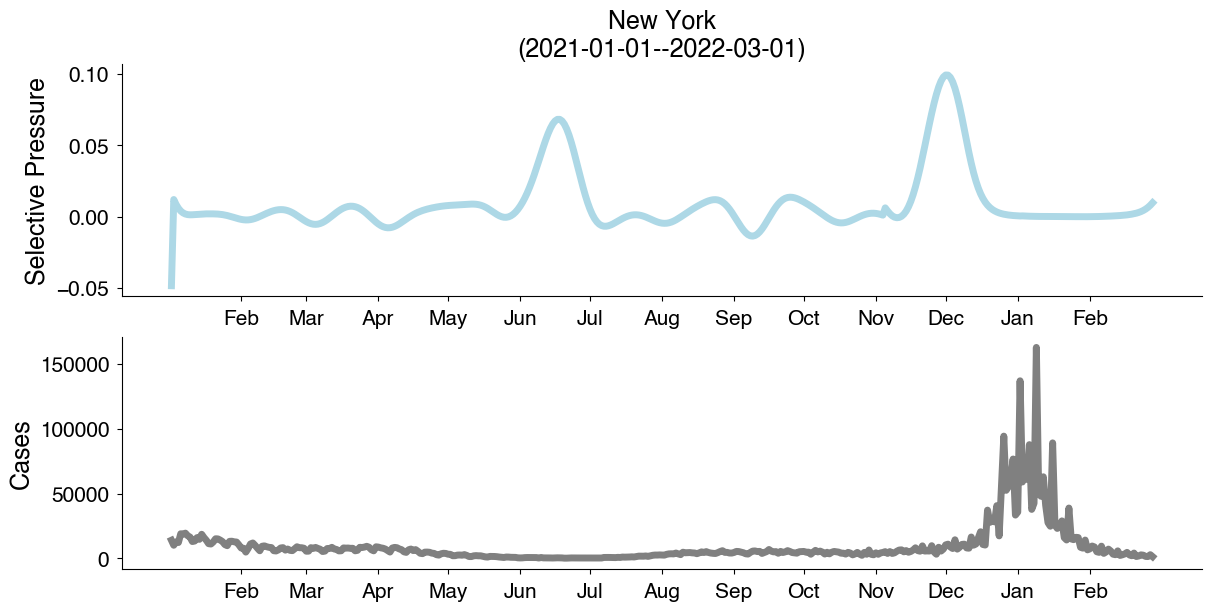

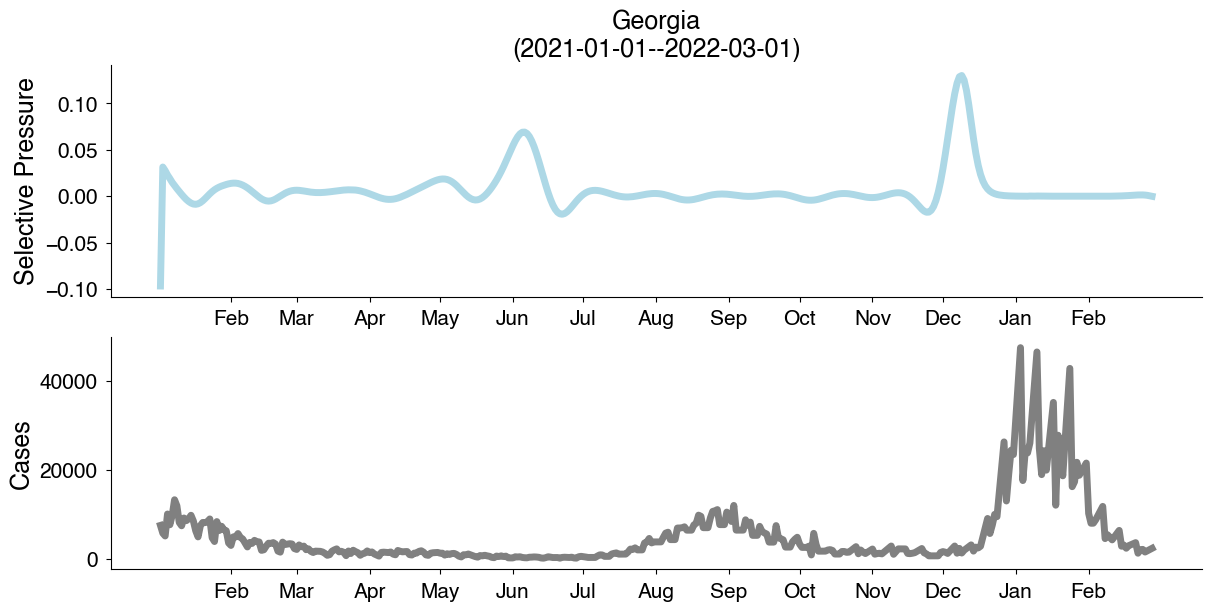

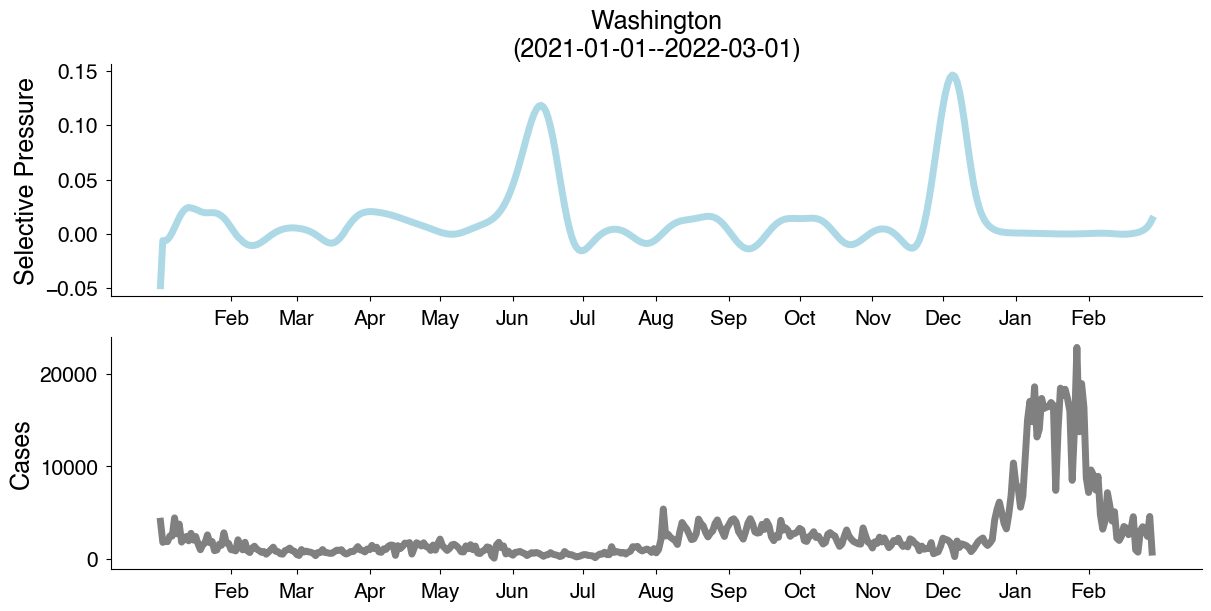

In [89]:
def plot_selective_pressure_cases(loc):
    # Compute selective pressure
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    
    fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=2)

    # Plot selective pressure
    ax0 = fig.add_subplot(spec[0, 0])
    ax0.plot(t, selective_pressure, color="lightblue")
    ax0.set_ylabel("Selective Pressure")
    add_dates(ax0, data[loc].dates)
    ax0.set_title(loc + f"\n({date_start}--{date_end})")

    # Plot cases
    ax1 = fig.add_subplot(spec[1, 0], sharex = ax0)
    t_cases = [i for i, t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    ax1.plot(t_cases, cases[loc].cases, color="gray")
    ax1.set_ylabel("Cases")
    return fig

fig_selective_pressure_cases = {}
for loc in locations:
    fig_selective_pressure_cases[loc] = plot_selective_pressure_cases(loc)
    fig_selective_pressure_cases[loc].savefig(f"figures/selective_pressure_cases_{loc}.png")
fig_selective_pressure_cases

{'California': <Figure size 1200x600 with 2 Axes>,
 'Florida': <Figure size 1200x600 with 2 Axes>,
 'Michigan': <Figure size 1200x600 with 2 Axes>,
 'New York': <Figure size 1200x600 with 2 Axes>,
 'Georgia': <Figure size 1200x600 with 2 Axes>,
 'Washington': <Figure size 1200x600 with 2 Axes>}

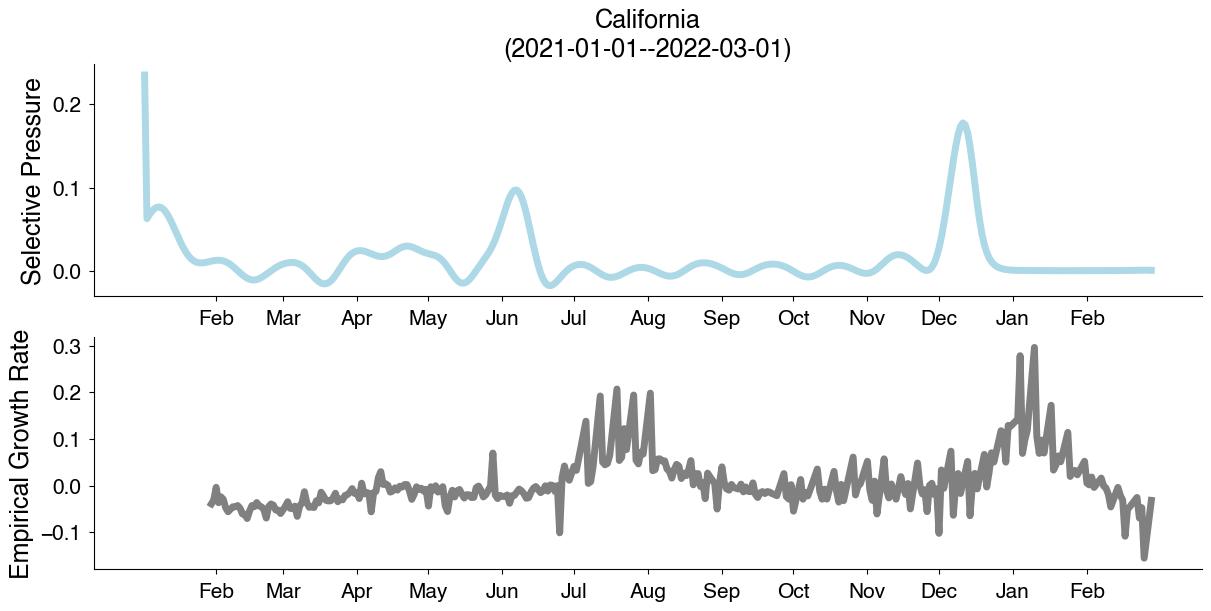

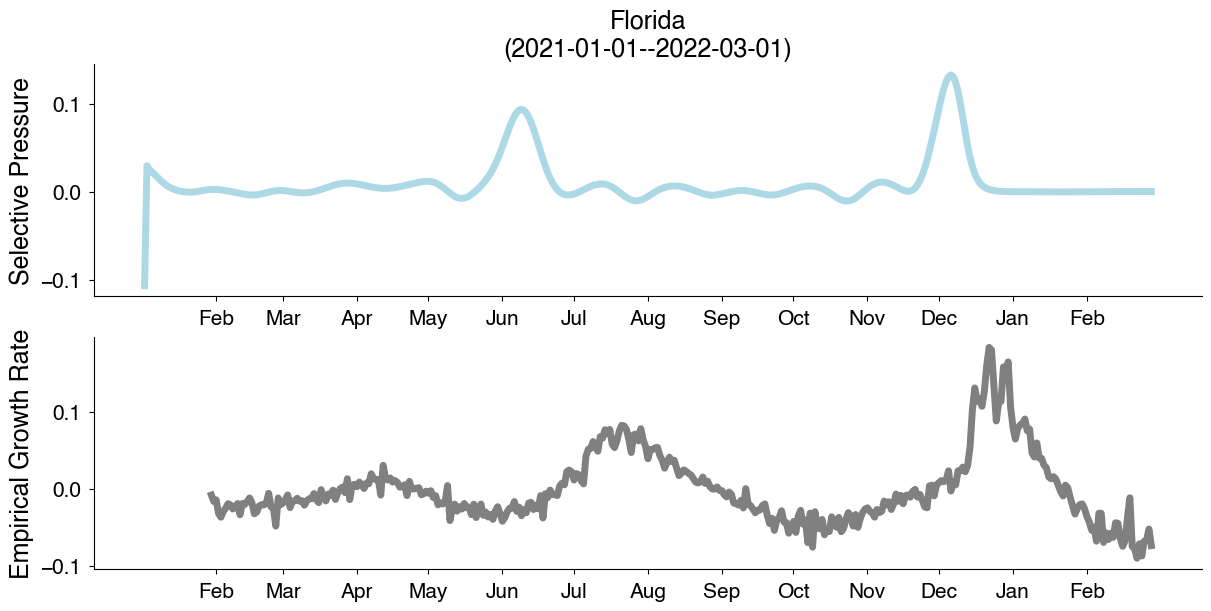

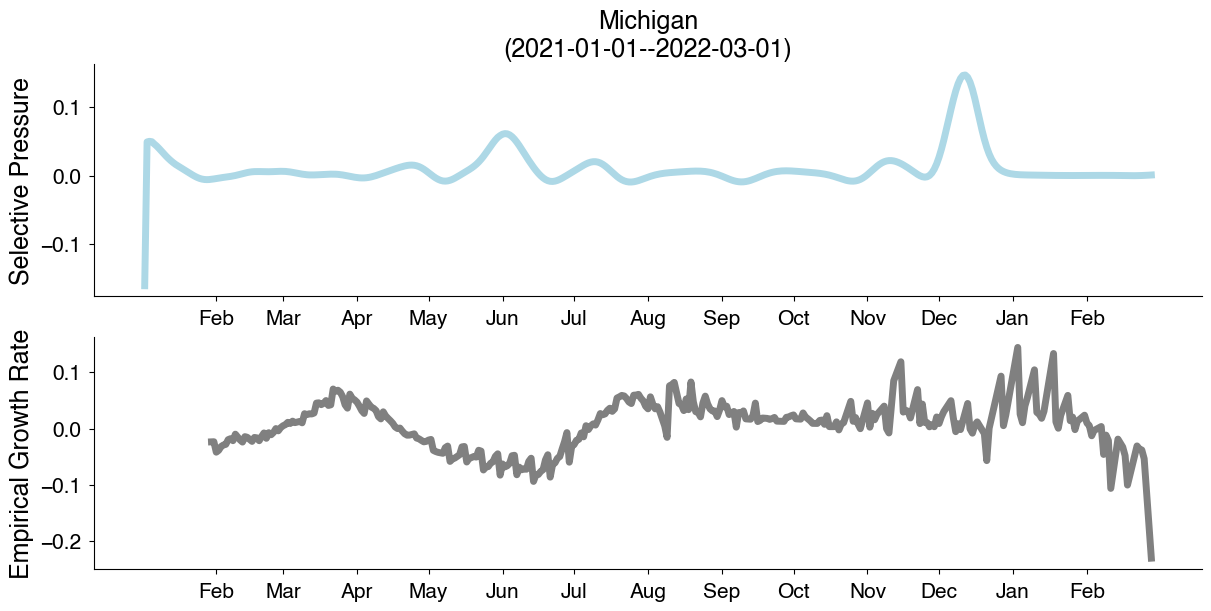

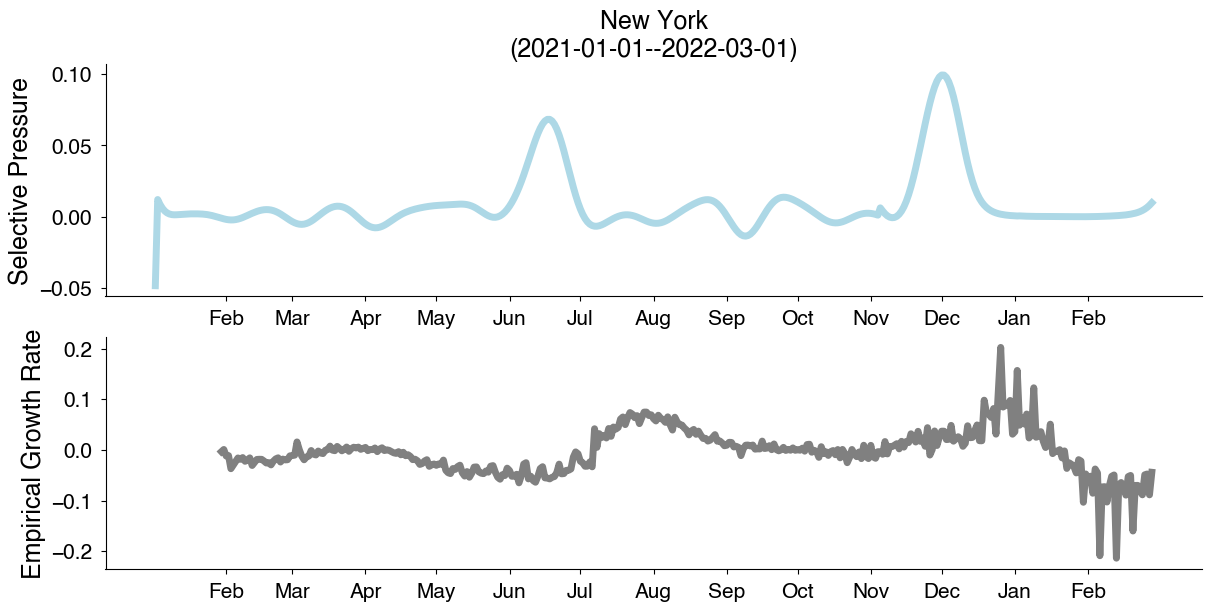

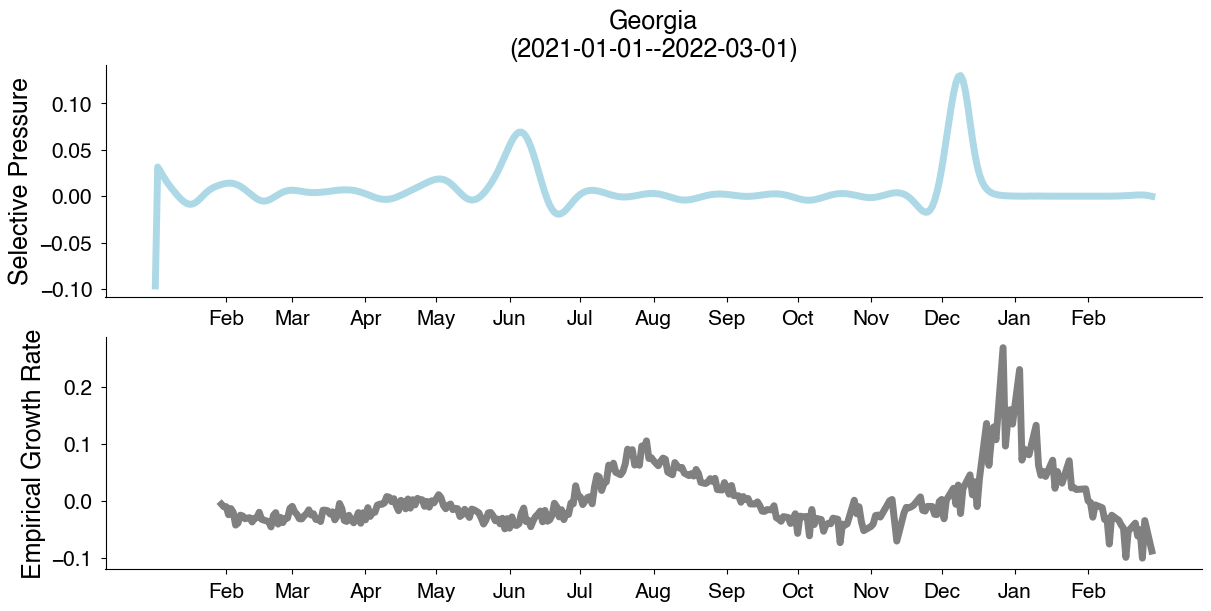

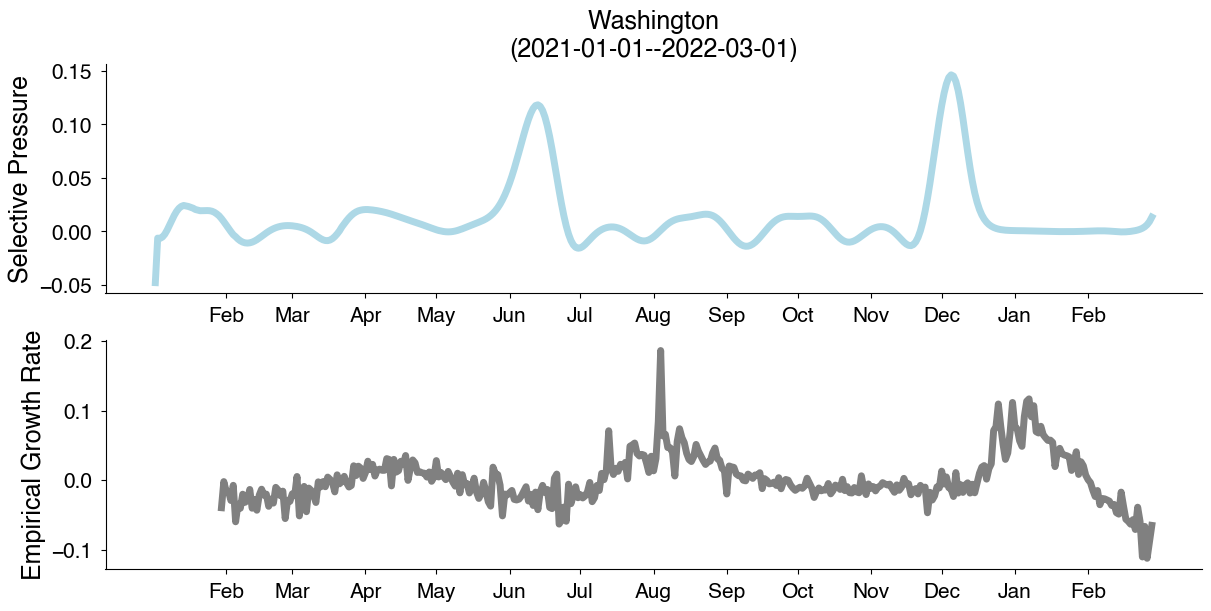

In [421]:
def moving_average(a, n=3):
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_selective_pressure_growth(loc, window_n):
    # Compute selective pressure
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    
    # Prep data
    t_cases = [i for i, t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    smooth_cases = moving_average(cases[loc].cases.values, n=window_n)
    empirical_growth = np.diff(np.log(smooth_cases))
    
    fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=2)

    # Plot selective pressure
    ax0 = fig.add_subplot(spec[0, 0])
    ax0.plot(t, selective_pressure, color="lightblue")
    ax0.set_ylabel("Selective Pressure")
    add_dates(ax0, data[loc].dates)
    ax0.set_title(loc + f"\n({date_start}--{date_end})")

    # Plot empirical growth rates
    ax1 = fig.add_subplot(spec[1, 0], sharex = ax0)
    ax1.plot(t_cases[window_n:], empirical_growth, color="gray")
    ax1.set_ylabel("Empirical Growth Rate")
    return fig

window_n = 28
fig_selective_pressure_growth = {}
for loc in locations:
    fig_selective_pressure_growth[loc] = plot_selective_pressure_growth(loc, window_n)
    fig_selective_pressure_growth[loc].savefig(f"figures/selective_pressure_growth_{loc}.png")
fig_selective_pressure_growth

In [422]:
def make_dataframes(loc):
    # Create selective pressure column for each date
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    selective_pressure_df = pd.DataFrame({"selective_pressure": selective_pressure[:,-1], "date": data[loc].dates})
    
    # Create smooth cases and empirical growth dataframe
    t_cases = [t for i,t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    smooth_cases = moving_average(cases[loc].cases.values, n=window_n)
    empirical_growth = np.diff(np.log(smooth_cases), prepend=np.nan)
    empirical_growth_change = np.diff(empirical_growth, prepend=np.nan)
    
    growth_df = pd.DataFrame({"date": t_cases[window_n-1:], 
                              "smooth_cases": smooth_cases, 
                              "empirical_growth_rate": empirical_growth,
                              "empirical_growth_change": empirical_growth_change
                             })
    # Merge on date
    selective_pressure_df = selective_pressure_df.merge(growth_df, on="date", how="left")
    selective_pressure_df["location"] = loc
    return selective_pressure_df

selective_pressure_dfs = {}
for loc in locations:
    selective_pressure_dfs[loc] = make_dataframes(loc)

selective_pressure_dfs["Washington"]

,selective_pressure,date,smooth_cases,empirical_growth_rate,empirical_growth_change,location
0,-0.047835,2021-01-02,NaN,NaN,NaN,Washington
1,-0.006240,2021-01-03,NaN,NaN,NaN,Washington
2,-0.006508,2021-01-04,NaN,NaN,NaN,Washington
3,-0.005252,2021-01-05,NaN,NaN,NaN,Washington
4,-0.002631,2021-01-06,NaN,NaN,NaN,Washington
...,...,...,...,...,...,...
418,0.002981,2022-02-24,5945.250000,-0.110132,-0.051304,Washington
419,0.004349,2022-02-25,5564.500000,-0.066185,0.043947,Washington
420,0.006320,2022-02-26,4974.607143,-0.112061,-0.045875,Washington
421,0.009184,2022-02-27,4553.214286,-0.088513,0.023548,Washington


In [436]:
def create_lagged_features(df, columns, max_lag, dropna=True):
    """
    Generate lagged predictors for specified columns in a pandas DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the original data.
    - columns: list of column names for which to generate lagged predictors.
    - max_lag: maximum number of lags to generate.
    - dropna: boolean indicating whether to drop rows with NaN values resulting from lagging.
    
    Returns:
    - A pandas DataFrame with original and lagged predictors.
    """
    result_df = df.copy()
    for col in columns:
        for lag in range(1, max_lag + 1):
            result_df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    if dropna:
        result_df = result_df.dropna().reset_index(drop=True)
    
    return result_df

input_dfs = {}
keep_features = ["selective_pressure"]
keep_targets = ["empirical_growth_rate"]
for loc in locations:
    input_dfs[loc] = create_lagged_features(
        selective_pressure_dfs[loc][keep_features + keep_targets], 
        ["selective_pressure"], 
        60)

input_dfs["California"]

,selective_pressure,empirical_growth_rate,selective_pressure_lag_1,selective_pressure_lag_2,selective_pressure_lag_3,selective_pressure_lag_4,selective_pressure_lag_5,selective_pressure_lag_6,selective_pressure_lag_7,selective_pressure_lag_8,...,selective_pressure_lag_51,selective_pressure_lag_52,selective_pressure_lag_53,selective_pressure_lag_54,selective_pressure_lag_55,selective_pressure_lag_56,selective_pressure_lag_57,selective_pressure_lag_58,selective_pressure_lag_59,selective_pressure_lag_60
0,0.009540,-0.034495,0.008866,0.007966,0.006829,0.005457,0.003854,0.002024,0.000030,-0.002078,...,0.070098,0.073593,0.075788,0.076613,0.076060,0.074255,0.071293,0.067312,0.062601,0.235197
1,0.009924,-0.048648,0.009540,0.008866,0.007966,0.006829,0.005457,0.003854,0.002024,0.000030,...,0.065504,0.070098,0.073593,0.075788,0.076613,0.076060,0.074255,0.071293,0.067312,0.062601
2,0.009999,-0.049456,0.009924,0.009540,0.008866,0.007966,0.006829,0.005457,0.003854,0.002024,...,0.060014,0.065504,0.070098,0.073593,0.075788,0.076613,0.076060,0.074255,0.071293,0.067312
3,0.009711,-0.043962,0.009999,0.009924,0.009540,0.008866,0.007966,0.006829,0.005457,0.003854,...,0.053913,0.060014,0.065504,0.070098,0.073593,0.075788,0.076613,0.076060,0.074255,0.071293
4,0.009007,-0.065766,0.009711,0.009999,0.009924,0.009540,0.008866,0.007966,0.006829,0.005457,...,0.047467,0.053913,0.060014,0.065504,0.070098,0.073593,0.075788,0.076613,0.076060,0.074255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.000661,-0.025338,0.000596,0.000529,0.000464,0.000404,0.000352,0.000309,0.000275,0.000250,...,0.000505,0.000617,0.000802,0.001078,0.001476,0.002036,0.002820,0.003918,0.005472,0.007690
301,0.000717,-0.069431,0.000661,0.000596,0.000529,0.000464,0.000404,0.000352,0.000309,0.000275,...,0.000438,0.000505,0.000617,0.000802,0.001078,0.001476,0.002036,0.002820,0.003918,0.005472
302,0.000755,-0.047264,0.000717,0.000661,0.000596,0.000529,0.000464,0.000404,0.000352,0.000309,...,0.000404,0.000438,0.000505,0.000617,0.000802,0.001078,0.001476,0.002036,0.002820,0.003918
303,0.000765,-0.155408,0.000755,0.000717,0.000661,0.000596,0.000529,0.000464,0.000404,0.000352,...,0.000388,0.000404,0.000438,0.000505,0.000617,0.000802,0.001078,0.001476,0.002036,0.002820


In [437]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor  # For regression
from sklearn.metrics import mean_squared_error

def process_inputs(loc, target):
    X = input_dfs[loc].drop(target, axis=1)  # Features
    y = input_dfs[loc][target]  # Target
    return X, y
    
X, y = process_inputs("Washington", target="empirical_growth_rate")

# Split to hold final section for testing best model after CV
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1e-2),
    'Lasso': Lasso(alpha=1e-6),
   # 'RandomForest': RandomForestRegressor(n_estimators=5, random_state=42, max_depth=3)
}
model_scores = {model: [] for model in models}

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Example: Iterate over the splits and print the train/val indices
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize and train your linear model within each split
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        mse = mean_squared_error(y_val, predictions)
        
        # Append the MSE to the model's list of scores
        model_scores[model_name].append(mse)

for model_name, scores in model_scores.items():
    print(f"{model_name}: Mean MSE = {np.mean(scores):.4f}, Std MSE = {np.std(scores):.4f}")
    
best_model_name = min(model_scores, key=lambda k: np.mean(model_scores[k]))

/Users/marlinfiggins/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.204e-06, tolerance: 1.445e-06
  model = cd_fast.enet_coordinate_descent(
/Users/marlinfiggins/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.923e-05, tolerance: 5.532e-06
  model = cd_fast.enet_coordinate_descent(
/Users/marlinfiggins/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

LinearRegression: Mean MSE = 0.0764, Std MSE = 0.1347
Ridge: Mean MSE = 0.0046, Std MSE = 0.0065
Lasso: Mean MSE = 0.0059, Std MSE = 0.0078


/Users/marlinfiggins/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e-03, tolerance: 1.711e-05
  model = cd_fast.enet_coordinate_descent(


In [438]:
# Retrain best model
best_model = models[best_model_name]
best_model.fit(X, y)
predictions = best_model.predict(X_test)

Text(0.5, 1.0, 'Testing set')

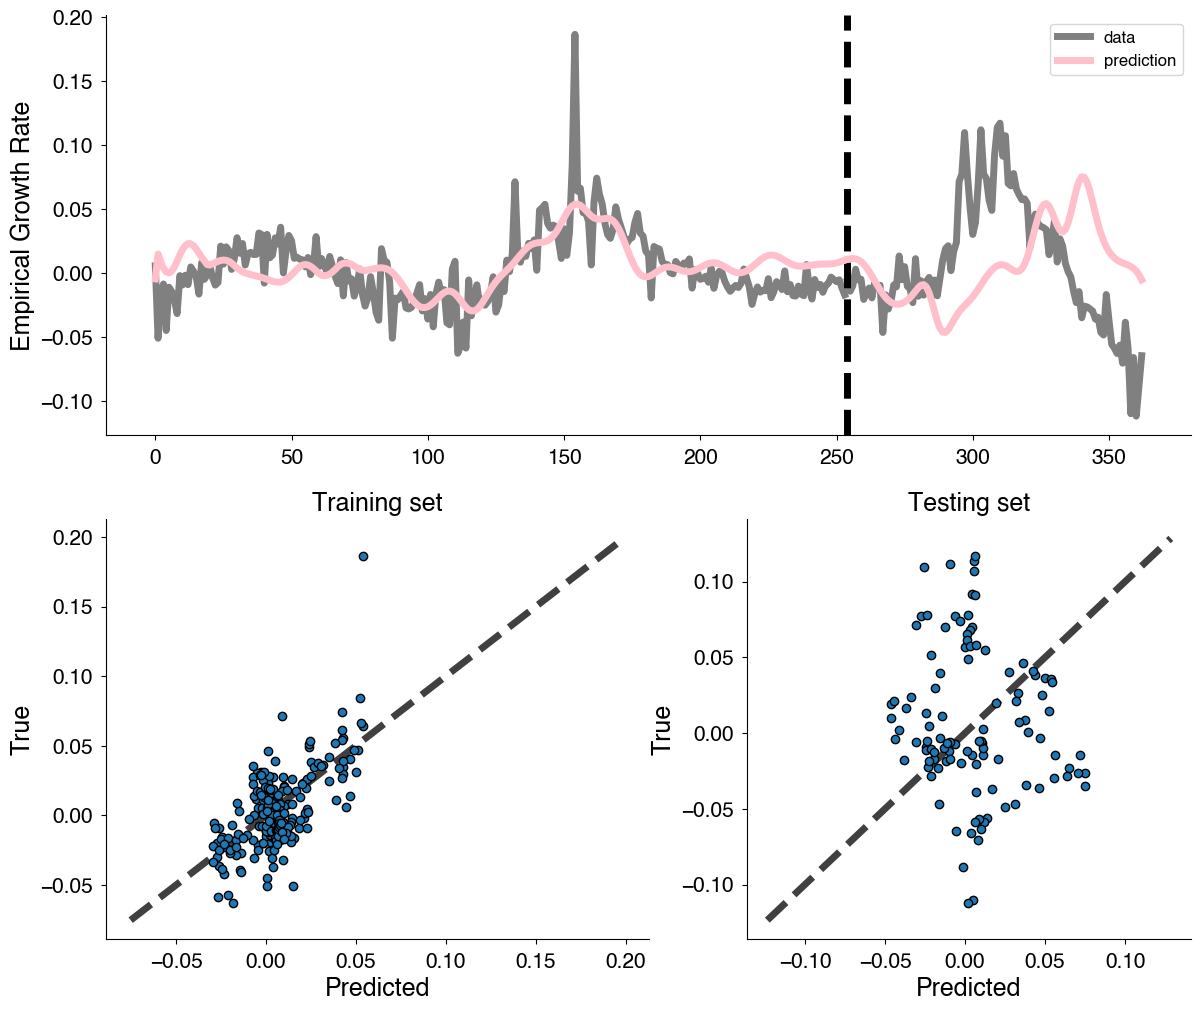

In [439]:
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(2, 2, width_ratios=[0.55, 0.45])

ax = fig.add_subplot(gs[0, :])
ax.plot(X.index, y, color="grey", label="data")
ax.plot(X_test.index, y_test, color="grey")
ax.axvline(x=X_test.index[0], color="k", linestyle="--")

ax.plot(X.index, model.predict(X), color="pink", label="prediction")
ax.plot(X_test.index, model.predict(X_test), color="pink")
ax.set_ylabel("Empirical Growth Rate")
ax.legend()

def plot_yeqx(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    return None

ax = fig.add_subplot(gs[1, 0])
ax.scatter(model.predict(X), y, ec="k")
plot_yeqx(ax)
ax.set_xlabel("Predicted"), ax.set_ylabel("True")
ax.set_title("Training set")

ax = fig.add_subplot(gs[1, 1])
ax.scatter(model.predict(X_test), y_test, ec="k")
plot_yeqx(ax)
ax.set_xlabel("Predicted"), ax.set_ylabel("True")
ax.set_title("Testing set")

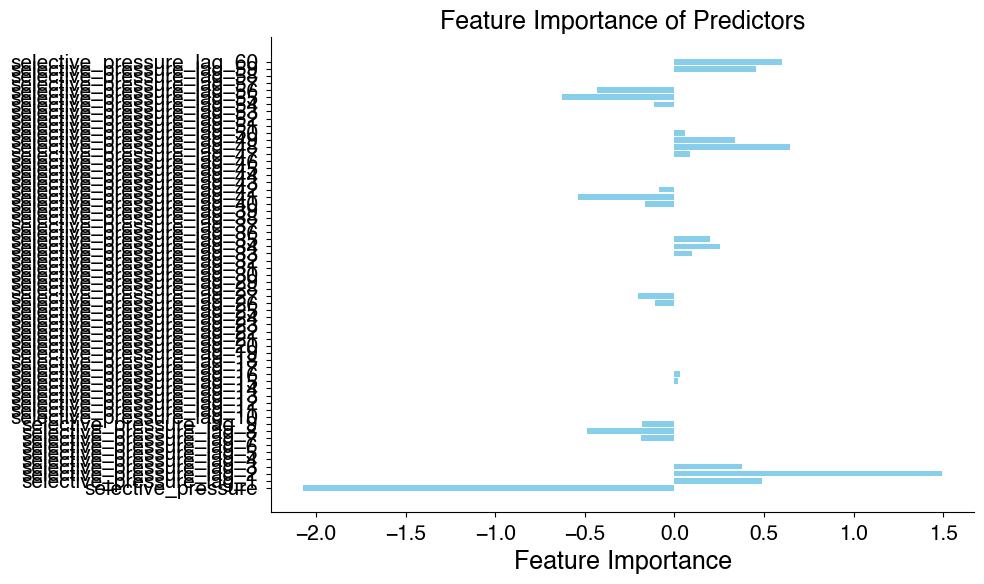

In [440]:
# Example feature importances and names
feature_importances = model.coef_ # Replace with your model's feature importances
#feature_importances = model.feature_importances_
feature_names = X.columns  # Replace with your actual feature names

# Create figure and gridspec
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 1)

# Create a subplot for feature importances
ax = fig.add_subplot(gs[0, 0])

# Plotting
indices = np.argsort(feature_importances)
indices = np.arange(feature_importances.shape[0])
ax.barh(range(len(indices)), feature_importances[indices], color='skyblue', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(np.array(feature_names)[indices])
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importance of Predictors')

plt.tight_layout()
plt.show()